In [145]:
import pandas as pd
import numpy as np

responses = pd.read_csv("../datasets/AITA_responses.csv")
print(responses.columns)

Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'heartatk', 'consent',
       'scenario_1_action', 'scenario_1_person', 's1t_First Click',
       's1t_Last Click', 's1t_Page Submit', 's1t_Click Count',
       'scenario_2_action', 'scenario_2_person', 's2t_First Click',
       's2t_Last Click', 's2t_Page Submit', 's2t_Click Count',
       'scenario_3_action', 'scenario_3_person', 's3t_First Click',
       's3t_Last Click', 's3t_Page Submit', 's3t_Click Count',
       'scenario_4_action', 'scenario_4_person', 's4t_First Click',
       's4t_Last Click', 's4t_Page Submit', 's4t_Click Count',
       'scenario_5_action', 'scenario_5_person', 's5t_First Click',
       's5t_Last Click', 's5t_Page Submit', 's5t_Click Count',

In [146]:
print(responses.shape)

(1474, 69)


In [147]:
print(responses['Progress'].value_counts())
print(responses['q_3_is_modified'].isna().sum())


100                        1350
10                           34
23                           18
74                           18
35                           13
48                           12
6                            10
77                            8
61                            5
3                             4
Progress                      1
{"ImportId":"progress"}       1
Name: Progress, dtype: int64
875


In [148]:
df = responses.loc[(responses["AC"] =="1")& (responses["consent"] =="1")]

print(df.shape) #should be around 770
colMax = {1: {"action":df["scenario_1_action"].astype("int").max(), "person":df["scenario_1_person"].astype("int").max()}, 2: {"action":df["scenario_2_action"].astype("int").max(), "person":df["scenario_2_person"].astype("int").max()}, 3: {"action":df["scenario_3_action"].astype("int").max(), "person":df["scenario_3_person"].astype("int").max()}, 4: {"action":df["scenario_4_action"].astype("int").max(), "person":df["scenario_4_person"].astype("int").max()}, 5: {"action":df["scenario_5_action"].astype("int").max(), "person":df["scenario_5_person"].astype("int").max()}, }
colMin = {1: {"action":df["scenario_1_action"].astype("int").min(), "person":df["scenario_1_person"].astype("int").min()}, 2: {"action":df["scenario_2_action"].astype("int").min(), "person":df["scenario_2_person"].astype("int").min()}, 3: {"action":df["scenario_3_action"].astype("int").min(), "person":df["scenario_3_person"].astype("int").min()}, 4: {"action":df["scenario_4_action"].astype("int").min(), "person":df["scenario_4_person"].astype("int").min()}, 5: {"action":df["scenario_5_action"].astype("int").min(), "person":df["scenario_5_person"].astype("int").min()}, }
print(colMax)
print(colMin)

(773, 69)
{1: {'action': 46, 'person': 44}, 2: {'action': 39, 'person': 37}, 3: {'action': 39, 'person': 37}, 4: {'action': 39, 'person': 37}, 5: {'action': 39, 'person': 37}}
{1: {'action': 40, 'person': 38}, 2: {'action': 33, 'person': 31}, 3: {'action': 33, 'person': 31}, 4: {'action': 33, 'person': 31}, 5: {'action': 33, 'person': 31}}


In [155]:
def recodeValues(columnIdx, isAction, value):
    key = "action" if isAction else "person"
    curColMax = colMax[columnIdx][key]
    curColMin = colMin[columnIdx][key]
    if curColMax-curColMin >6:
        raise Exception('Range too large') 
    else:
        return value-curColMin+1
    

new_format =[]
# New format is: id, is_modified, answer_action,answer_person
for index, row in df.iterrows():

    age = -1 if str(row["age"]).strip().lower() == "nan" else int(row["age"])
    #TODO:Skip nan gender & age?
    if str(row["gender"]).strip().lower() == "nan":
        print("shitty")
        #continue

    r1 = [row["q_1_id"], 1 if row["q_1_is_modified"] == "true" else -1, recodeValues(1, True, int(row["scenario_1_action"])), recodeValues(1, False, int(row["scenario_1_person"])), age, row["gender"]]
    r2 = [row["q_2_id"], 1 if row["q_2_is_modified"] == "true" else -1, recodeValues(2, True, int(row["scenario_2_action"])), recodeValues(2, False, int(row["scenario_2_person"])), age, row["gender"]]
    r3 = [row["q_3_id"], 1 if row["q_3_is_modified"] == "true" else -1, recodeValues(3, True, int(row["scenario_3_action"])), recodeValues(3, False, int(row["scenario_3_person"])), age, row["gender"]]
    r4 = [row["q_4_id"], 1 if row["q_4_is_modified"] == "true" else -1, recodeValues(4, True, int(row["scenario_4_action"])), recodeValues(4, False, int(row["scenario_4_person"])), age, row["gender"]]
    r5 = [row["q_5_id"], 1 if row["q_5_is_modified"] == "true" else -1, recodeValues(5, True, int(row["scenario_5_action"])), recodeValues(5, False, int(row["scenario_5_person"])), age, row["gender"]]
    new_format += [r1, r2,r3,r4,r5]

df_new_format = pd.DataFrame(np.array(new_format), columns=['scenarioId', 'isModified', 'scenarioAction', 'scenarioPerson', "age", "gender"], )
df_new_format["isModified"] = df_new_format["isModified"].astype("int")
df_new_format["scenarioAction"] = df_new_format["scenarioAction"].astype("int")
df_new_format["scenarioPerson"] = df_new_format["scenarioPerson"].astype("int")
df_new_format["age"] = df_new_format["age"].astype("int")

shitty
shitty
shitty


In [156]:
print(df_new_format.shape)
print(df_new_format.dtypes)

(3865, 6)
scenarioId        object
isModified         int64
scenarioAction     int64
scenarioPerson     int64
age                int64
gender            object
dtype: object


In [169]:
print(df_new_format['isModified'].value_counts())
print(df_new_format.isna().sum())
print(df_new_format.isin(['nan']).sum(axis=0))

 1    1959
-1    1906
Name: isModified, dtype: int64
scenarioId        0
isModified        0
scenarioAction    0
scenarioPerson    0
age               0
gender            0
dtype: int64
scenarioId         0
isModified         0
scenarioAction     0
scenarioPerson     0
age                0
gender            15
dtype: int64


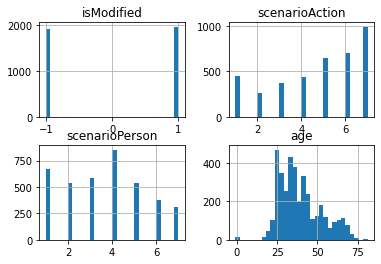

In [158]:
hist = df_new_format.hist(bins=30)

In [159]:
df_new_format.to_excel("aita_data_transformed.xlsx")